# Neural Network Text Classification with TensorFlow
**Dataset**: [Wine Reviews - Kaggle](https://www.kaggle.com/datasets/zynicide/wine-reviews/data?select=winemag-data_first150k.csv)

### Import the necessary libraries 

In [2]:
# for numerical computation/ array operation
import numpy as np
# for data manipulation
import pandas as pd
# for graph plotting 
import matplotlib.pyplot as plt
# for neural networks
import tensorflow as tf

### Load the data

In [3]:
# read the data
df = pd.read_csv("data/wine_reviews.csv")

In [5]:
# Load wine review data from CSV file, selecting only specific columns needed for analysis
df = pd.read_csv("data/wine_reviews.csv", usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])

In [6]:
# view some data
df.head()

,country,description,points,price,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,96,235.0,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",96,110.0,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,96,90.0,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",96,65.0,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",95,66.0,Provence red blend,Domaine de la Bégude


In [7]:
# check the shape
df.shape

(150930, 6)

In [8]:
# Check for null values
df.isna().sum()

country            5
description        0
points             0
price          13695
variety            0
winery             0
dtype: int64

In [9]:
# let's drop the nan values
df.dropna(subset=['country', 'price'], axis=0, inplace=True)

Text(0.5, 1.0, 'Points Histogram')

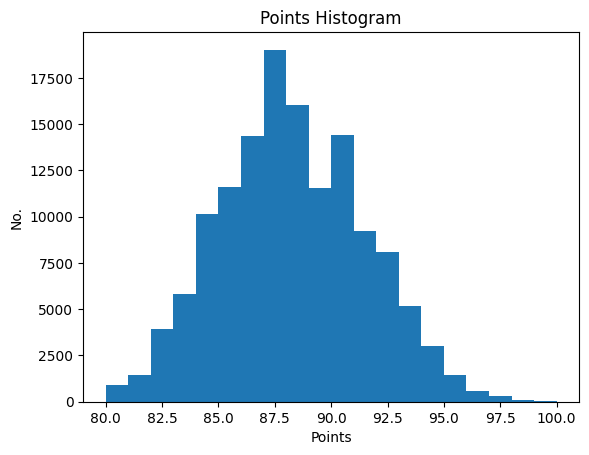

In [10]:
# Plot the points column
plt.hist(df.points, bins=20)
plt.ylabel("No.")
plt.xlabel("Points")
plt.title("Points Histogram")

In [11]:
# view some descriptive stats
df.describe()

,points,price
count,137230.000000,137230.000000
mean,87.788035,33.132019
std,3.221572,36.323072
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,24.000000
75%,90.000000,40.000000
max,100.000000,2300.000000


In [12]:
# lets make the quality label based on points (dividing into low tier and high tier)
df['label'] = (df.points > 88).astype(int)

# use the required column only
df = df[['description', 'label']]

In [13]:
# lets see the changes
df.sample(5)

,description,label
114316,"Lush and full-bodied, if not especially comple...",0
19457,The 2006 L'Ermite boasts a wonderfully fragran...,1
1803,"Woodland berry, pressed violet, dark cooking s...",1
7464,"Soft and soapy, this is a simple wine without ...",0
18699,Forward citrus is lifted by accents of thyme a...,0


#### [Split the data](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) 

In [15]:
# Shuffle the dataset before splitting
df = df.sample(frac=1, random_state=24)  

# Define split indices
train_idx = int(0.8 * len(df))  # 80% of data for training
val_idx = int(0.9 * len(df))    # Next 10% for validation

# Split the dataset into training, validation, and test sets
train, val, test = np.split(df, [train_idx, val_idx])

In [16]:
# Check the lengths of 'train', 'val', and 'test'
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

109784 training examples
13723 validation examples
13723 test examples


#### Lets convets these datas to tensorflow datasets
> **Using: [Classify structured data using Keras preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers)**
> > create a utility function that converts each training, validation, and test set DataFrame into a `tf.data.Dataset`, then shuffles and batches the data.

In [17]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
    df = dataframe.copy()
    labels = df[['label']]  # Extract labels
    df = df.drop(columns=['label'])  # Keep remaining features
    
    ds = tf.data.Dataset.from_tensor_slices((df['description'], labels))  # Convert DataFrame to a dict
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))  # Shuffle dataset
    
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Optimize loading performance
    return ds

In [18]:
# convert to the dataset
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [19]:
# lets see the data
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b'Sharp, cutting acidity mars this delicately-structured wine. Tastes like a good dose of lime juice was added. Otherwise, the raspberry, orange and pomegranate flavors are delicious and dry.',
        b'They pulled out their best for their birthday, and the result is a spectacular wine. Dense and concentrated in enormously complex cassis, black currant, cherry pie and cedar, it shows the dryness and firm tannins of a fine young Cabernet. Easy to predict a good lifetime ahead. Give it a year to resolve, and then should develop slowly for another six to eight years, at least.',
        b'A lovely wine, rich and exotic, yet dry and balanced. Shows exotic flavors of spiced pears, pineapple punch, honeysuckles, butterscotch and Asian spices, in a creamy texture. Roussanne, Grenache Blanc and Viognier.',
        ...,
        b'Typical of a young, fine Petite Sirah, this bottle is too tannic and unintegrated to drink now. But it has a 

## **Embedding Text Features**
Since our features are in **text format**, we need to convert them into a **numerical representation** so that our model can process them.  
We will achieve this using **TensorFlow Hub**, which provides **pre-trained models** for embedding.  
One of the available models for this task is **Google's NNLM**, which can be found on [Kaggle](https://www.kaggle.com/models/google/nnlm).  
Using these embeddings ensures that our model captures **semantic relationships** between words, improving its understanding of textual data.  

**Install TensorFlow Hub**
```shell
! pip install tensorflow-hub
```

In [23]:
# Import TensorFlow Hub for pre-trained models
import tensorflow_hub as hub 

# Import warnings
import warnings
warnings.filterwarnings("ignore")   # Suppress all warnings


In [24]:
# Load a pre-trained text embedding model from TensorFlow Hub
hub_layer = hub.KerasLayer(
    "https://www.kaggle.com/models/google/nnlm/TensorFlow2/de-dim128/1",  # URL of the NNLM model
    input_shape=[],  # Specifies input shape (expects single strings)
    dtype=tf.string,  # Defines input data type as string (since we're working with text)
    trainable=True  # Allows fine-tuning of the embedding model during training
)

In [22]:
# This layer will convert input text into numerical embeddings
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 128), dtype=float32, numpy=
array([[-0.18380183,  0.16711012, -0.35028955, ..., -0.33941844,
        -0.33396477, -0.22573747],
       [-0.25426242,  0.02310776, -0.19508821, ..., -0.11212113,
        -0.26939538,  0.11686062],
       [-0.03258701,  0.208426  , -0.30258024, ..., -0.19856066,
        -0.14358364, -0.08963242],
       ...,
       [-0.3107113 ,  0.07128148, -0.43521076, ..., -0.28439024,
        -0.37688944,  0.03392216],
       [-0.2592677 ,  0.2806191 , -0.2707957 , ..., -0.19513129,
        -0.26001784, -0.04836067],
       [-0.343174  ,  0.2351944 , -0.3969177 , ..., -0.2967693 ,
        -0.45732522,  0.16782576]], dtype=float32)>

### Model Training

In [32]:
# 1. Create a Sequential model
model = tf.keras.Sequential()
# Add a Lambda layer to apply the pre-trained embedding model
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(x)))  # Converts text input into numerical embeddings
model.add(tf.keras.layers.Dense(16, activation='relu'))  # First hidden layer with 16 units
model.add(tf.keras.layers.Dense(16, activation='relu'))  # Second hidden layer with 16 units
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # Single unit for binary classification
# Print model architecture summary
model.summary()  # Displays model structure and parameters

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# 2. compile the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 3. fit the data into model
history = model.fit(train_data,
                    epochs=10,
                    validation_data=val_data
                   )

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.5935 - loss: 0.6785 - val_accuracy: 0.6117 - val_loss: 0.6473
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6479 - loss: 0.6286 - val_accuracy: 0.7004 - val_loss: 0.5755
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7074 - loss: 0.5681 - val_accuracy: 0.7154 - val_loss: 0.5518
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7211 - loss: 0.5481 - val_accuracy: 0.7240 - val_loss: 0.5442
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7253 - loss: 0.5422 - val_accuracy: 0.7220 - val_loss: 0.5428
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7236 - loss: 0.5419 - val_accuracy: 0.7236 - val_loss: 0.5421
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7286 - loss: 0.5373 - val_accuracy: 0.7234 - val_loss: 0.5423
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.7245 - loss: 0.5394 - val_accu

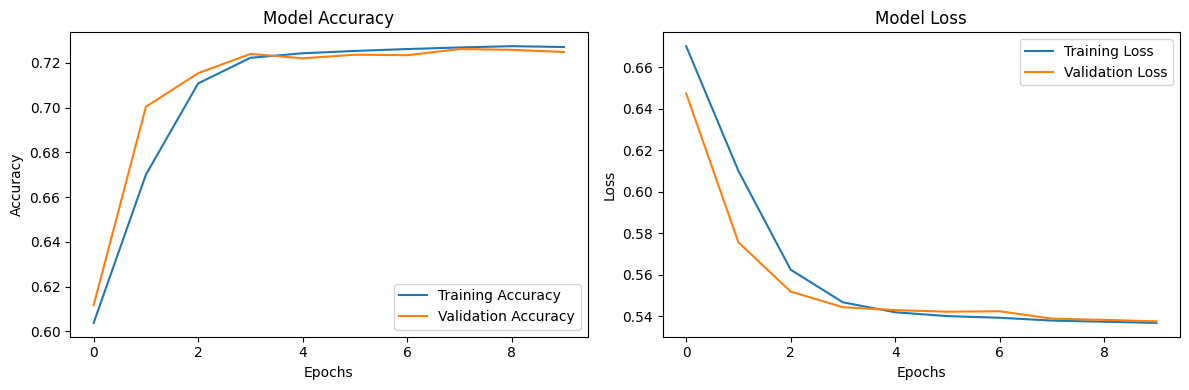

In [42]:
# lets plot the metrics
history_df = pd.DataFrame(history.history) # Create DataFrame from history

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot accuracy
ax1.plot(history_df['accuracy'], label='Training Accuracy')
ax1.plot(history_df['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')
ax1.legend()

# Plot loss
ax2.plot(history_df['loss'], label='Training Loss')
ax2.plot(history_df['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')
ax2.legend()

plt.tight_layout()
plt.show()

#### **Insights from the Training Logs and Plot:**
* **Convergence:**
    * From Epoch 3 onwards, the accuracy and loss values for both training and validation seem to stabilize, indicating that the model is converging.
    * Specifically, from Epoch 5 to Epoch 10, the changes in accuracy and loss are very minimal (e.g., training accuracy goes from 0.7253 to 0.7272, and validation accuracy from 0.7220 to 0.7248).
* **Validation vs. Training Performance:**
    * Initially (Epoch 1), the validation accuracy (0.6117) is slightly higher than the training accuracy (0.5935), and validation loss (0.6473) is slightly lower than training loss (0.6785). This is not uncommon in the very early stages of training.
    * As training progresses, the training accuracy consistently stays very close to the validation accuracy, and similarly for the loss values. For instance, at Epoch 10, training accuracy is 0.7272 and validation accuracy is 0.7248. Training loss is 0.5361 and validation loss is 0.5381. The differences are very small.

* **Small Gap:** The gap between training metrics and validation metrics remains small throughout the training process and does not significantly widen. A widening gap is a strong indicator of overfitting.

> While it's not severe overfitting, the model does seem to have **converged and reached a plateau** in its performance.

**Note -** *[Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)*: A technique to prevent overfitting by randomly deactivating (dropping out) a percentage of neurons during training, forcing the network to learn more robust features and improve generalization .
```python
model.add(tf.keras.layers.Dropout(0.4))
```

In [43]:
# Lets evaluate the model on test data
model.evaluate(test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.7233 - loss: 0.5360


[0.5373629927635193, 0.7230926156044006]

>✅ **We trained our model and reached 72% classification performance (without overfitting).**

## **Building a Text Classification Model Without Pretrained Embeddings**  
Instead of using pretrained embeddings (like Word2Vec, GloVe, or TensorFlow Hub models), we will create our own classification model using **LSTM** for sequential text processing. We'll train our own embeddings from scratch using Keras embedding layers.

### **Key Components for Text Encoding**

- **`tf.keras.layers.TextVectorization`**  
  A preprocessing layer that converts raw text into integer sequences based on a vocabulary. It handles tokenization, lowercasing, and maps each unique word to an integer index.

- **`tf.keras.layers.Embedding`**  
  Maps integer indices (from text vectorization) to dense vector representations of fixed size. This layer learns semantic relationships between words during training, creating custom embeddings specific to your dataset.

### Define preprocessing layers for text classification

#### Text Vectorization Layer

In [71]:
# Hyperparameters for text processing
max_vocab_size = 2000  # Keep only top 2000 most frequent words (reduces noise)
max_seq_length = 100    # Pad/truncate all sequences to this length (for consistent input size)

# Create the text vectorization layer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_vocab_size,          # Vocabulary size limit (most frequent words only)
    output_mode='int',                  # Output integer indices (not one-hot encoding)
    output_sequence_length=max_seq_length,  # Fixed sequence length for all inputs
    name='text_vectorizer'

)

# Now that the vocab layer has been created, call `adapt` on the list of strings to create the vocabulary.
text_vectorizer.adapt(train_data.map(lambda text, label: text))

In [72]:
# Get the vocabulary as a numpy array to inspect it
vocab = np.array(text_vectorizer.get_vocabulary())  
print(f"First 20 vocabulary words (most frequent):\n{vocab[:20]}")

First 20 vocabulary words (most frequent):
['' '[UNK]' 'and' 'the' 'a' 'of' 'with' 'this' 'is' 'wine' 'flavors' 'in'
 'to' 'it' 'its' 'fruit' 'but' 'on' 'that' 'finish']


#### Embedding Layer

In [73]:
# Create the embedding layer
embedder = tf.keras.layers.Embedding(
    input_dim=max_vocab_size,     # Input vocabulary size (must match text_vectorizer)
    output_dim=32,               # Embedding dimension (each word → 32-dim vector)
    mask_zero=True,               # Ignore padding tokens (index 0) in subsequent layers
    name='word_embeddings'        # Layer name for easier debugging
)

In [74]:
# Build the LSTM model using preprocessing layer
model = tf.keras.Sequential([
    text_vectorizer,  # Convert text into integer sequences
    embedder,  # converts integers to embeddings
    tf.keras.layers.LSTM(64),  # LSTM layer with 64 units
    tf.keras.layers.Dense(16, activation='relu'),  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorizer (TextVectorization)  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ word_embeddings (Embedding)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [76]:
# lets evalute the model
model.evaluate(train_data)

108/108 ━━━━━━━━━━━━━━━━━━━━ 44s 401ms/step - accuracy: 0.4595 - loss: 0.6934


[0.6933507919311523, 0.4590924084186554]

In [77]:
# fit the data into model for training 
history = model.fit(train_data, epochs=7, validation_data=val_data)

Epoch 1/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 100s 907ms/step - accuracy: 0.6653 - loss: 0.5936 - val_accuracy: 0.8274 - val_loss: 0.3733
Epoch 2/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8379 - loss: 0.3570 - val_accuracy: 0.8419 - val_loss: 0.3492
Epoch 3/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8459 - loss: 0.3386 - val_accuracy: 0.8435 - val_loss: 0.3443
Epoch 4/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.8509 - loss: 0.3296 - val_accuracy: 0.8455 - val_loss: 0.3357
Epoch 5/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 229s 2s/step - accuracy: 0.8520 - loss: 0.3268 - val_accuracy: 0.8446 - val_loss: 0.3403
Epoch 6/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.8539 - loss: 0.3214 - val_accuracy: 0.8403 - val_loss: 0.3461
Epoch 7/7
108/108 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.8544 - loss: 0.3199 - val_accuracy: 0.8459 - val_loss: 0.3365


<Axes: >

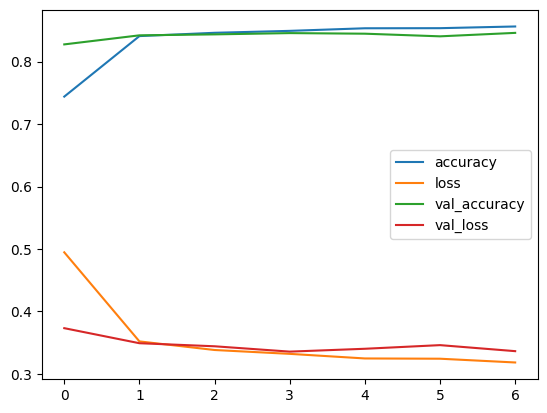

In [78]:
# Let's plot the loss and accuracy to see performance of model
pd.DataFrame(history.history).plot()

In [79]:
# evaluate the model
model.evaluate(test_data)

14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 913ms/step - accuracy: 0.8434 - loss: 0.3417


[0.3421556055545807, 0.8407782316207886]

### **Improvements:**
As the number of epochs increases, we notice a growing gap between training accuracy and validation accuracy. This suggests possible `overfitting`, where the model performs well on training data but struggles to generalize to unseen data. To mitigate this, we can introduce a **Dropout layer**, which helps prevent overfitting by randomly disabling neurons during training.

In [80]:
# 1. make model
model = tf.keras.Sequential([
    text_vectorizer,  
    embedder,  
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.40),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

# 2. Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss="binary_crossentropy", 
    metrics=["accuracy"]
)

# 3. fit the data
history = model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 316s 3s/step - accuracy: 0.7253 - loss: 0.5264 - val_accuracy: 0.8372 - val_loss: 0.3645
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 280s 3s/step - accuracy: 0.8442 - loss: 0.3528 - val_accuracy: 0.8417 - val_loss: 0.3433
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 293s 3s/step - accuracy: 0.8513 - loss: 0.3373 - val_accuracy: 0.8469 - val_loss: 0.3339
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.8551 - loss: 0.3256 - val_accuracy: 0.8464 - val_loss: 0.3451
Epoch 5/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.8593 - loss: 0.3167 - val_accuracy: 0.8460 - val_loss: 0.3371


<Axes: >

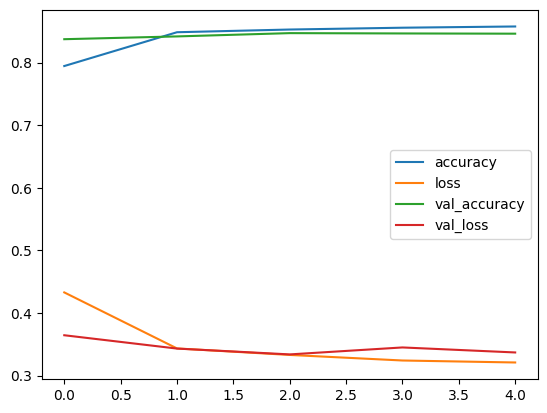

In [81]:
# Let's plot the loss and accuracy to see performance of model
pd.DataFrame(history.history).plot()

In [82]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorizer (TextVectorization)  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ word_embeddings (Embedding)          │ (None, 100, 32)             │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 64)                  │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 274,373 (1.05 MB)

 Trainable params: 91,457 (357.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 182,916 (714.52 KB)